# **Library**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf

from keras.preprocessing.text import one_hot, Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/CSE440-Online Sexism/All Data/EDOS Labelled Aggregated/train.csv")
data_val = pd.read_csv("/content/drive/MyDrive/CSE440-Online Sexism/All Data/EDOS Labelled Aggregated/val.csv")
data_test = pd.read_csv("/content/drive/MyDrive/CSE440-Online Sexism/All Data/EDOS Labelled Aggregated/test.csv")

# **Info**

In [ ]:
data.head()

,rewire_id,text,label_sexist,label_category,label_vector,split
0,sexism2022_english-16993,"Then, she's a keeper. 😉",not sexist,none,none,train
1,sexism2022_english-13149,This is like the Metallica video where the poo...,not sexist,none,none,train
2,sexism2022_english-13021,woman?,not sexist,none,none,train
3,sexism2022_english-14998,Unlicensed day care worker reportedly tells co...,not sexist,none,none,train
4,sexism2022_english-7228,[USER] Leg day is easy. Hot girls who wear min...,sexist,3. animosity,3.3 backhanded gendered compliments,train


In [ ]:
data.shape

(14000, 6)

In [ ]:
data_val.shape

(2000, 6)

In [ ]:
data_test.shape

(4000, 6)

# **Train Test Val Data**

In [ ]:
x_train = data.text.values
y_train = data.label_sexist.values

In [ ]:
x_val = data_val.text.values
y_val = data_val.label_sexist.values

In [ ]:
x_test = data_test.text.values
y_test = data_test.label_sexist.values

# **Embedding**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_Train = tokenizer.texts_to_sequences(x_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
x_Val = tokenizer.texts_to_sequences(x_val)
x_Test = tokenizer.texts_to_sequences(x_test)

Found 22628 unique tokens.


In [ ]:
# Padding all reviews to fixed length 65

maxlen = 60

x_train = pad_sequences(x_Train, padding='post', maxlen=maxlen, truncating='post')
x_val = pad_sequences(x_Val, padding='post', maxlen=maxlen, truncating='post')
x_test = pad_sequences(x_Test, padding='post', maxlen=maxlen, truncating='post')

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(tokenizer.word_index) + 1

vocab_length

22629

In [ ]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/CSE440-Online Sexism/All Data/Embedding/glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 300 columns
# Containing 300-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = np.zeros((vocab_length, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(22629, 300)

# **Metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
met = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
       tf.keras.metrics.Precision(name='precision'),
       tf.keras.metrics.Recall(name='recall')]

# **Checkpoint**

In [ ]:
checkpoint_lstm = ModelCheckpoint(filepath='/content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/LSTM/lstm-{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_freq="epoch", save_best_only=True, mode='min')

checkpoint_gru = ModelCheckpoint(filepath='/content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/GRU/gru-{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_freq="epoch", save_best_only=True, mode='min')

checkpoint_cnn = ModelCheckpoint(filepath='/content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/CNN/cnn-{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_freq="epoch", save_best_only=True, mode='min')

# **Early Stop**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=3, restore_best_weights=True)

# **Encode**

In [ ]:
encoding = {
    'sexist': 0,
    'not sexist': 1
}

In [ ]:
# Integer values for each class
y_train = [encoding[x] for x in y_train]
y_val = [encoding[x] for x in y_val]
y_test = [encoding[x] for x in y_test]

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# **LSTM (RNN)**

In [ ]:
from keras.layers import Bidirectional
from keras.layers import LSTM

In [ ]:
# LSTM
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
#lstm_model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
#lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, activation='sigmoid', return_sequences=True))
lstm_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, activation='relu')))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=met)
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           6788700   
                                                                 
 bidirectional (Bidirection  (None, 60, 1024)          3330048   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               557568    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 10676445 (40.73 MB)
Trainable params: 3887745 (14.83 MB)
Non-trainable params: 6788700 (25.90 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(x_train, y_train, batch_size=1024, epochs=30, verbose=1, validation_data=(x_val, y_val), callbacks=[checkpoint_lstm, early_stopping])

Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.7217 - precision: 0.7573 - recall: 0.9310
Epoch 1: val_loss improved from inf to 0.54001, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/LSTM/lstm-01-0.5400.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 42s 1s/step - loss: 0.5861 - accuracy: 0.7217 - precision: 0.7573 - recall: 0.9310 - val_loss: 0.5400 - val_accuracy: 0.7570 - val_precision: 0.7570 - val_recall: 1.0000
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7599 - precision: 0.7623 - recall: 0.9925
Epoch 2: val_loss improved from 0.54001 to 0.49066, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/LSTM/lstm-02-0.4907.hdf5
14/14 [==============================] - 20s 1s/step - loss: 0.5270 - accuracy: 0.7599 - precision: 0.7623 - recall: 0.9925 - val_loss: 0.4907 - val_accuracy: 0.7625 - val_precision: 0.8098 - val_recall: 0.8970
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.7684 - precision: 0.7830 - recall: 0.9604
Epoch 3: val_loss improved from 0.49066 to 0.48345, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/LSTM/lstm-03-0.4835.hdf5
14

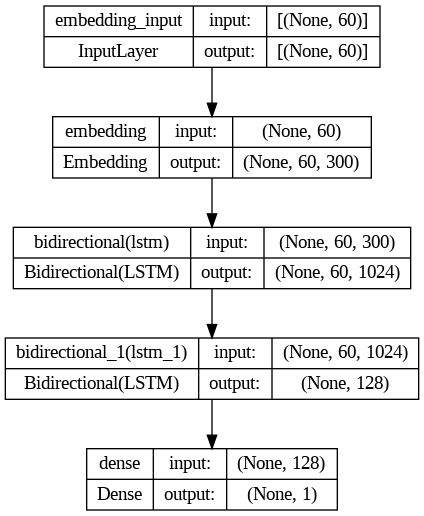

In [ ]:
#Plot Model Arch.
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(x_test, y_test, verbose=1)

125/125 [==============================] - 14s 116ms/step - loss: 0.3899 - accuracy: 0.8357 - precision: 0.8410 - recall: 0.9657


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.38990849256515503
Test Accuracy: 0.8357499837875366


In [ ]:
preds = lstm_model.predict(x_test)
preds = [round(x[0]) for x in preds]
print(classification_report(y_test,preds))

125/125 [==============================] - 13s 94ms/step
              precision    recall  f1-score   support

           0       0.80      0.43      0.56       970
           1       0.84      0.97      0.90      3030

    accuracy                           0.84      4000
   macro avg       0.82      0.70      0.73      4000
weighted avg       0.83      0.84      0.82      4000



In [ ]:
# Generate a confusion matrix
confusion = confusion_matrix(y_test, preds)
print("Confusion Matrix for Test Data using LSTM")
print(confusion)

Confusion Matrix for Test Data using LSTM
[[ 417  553]
 [ 104 2926]]


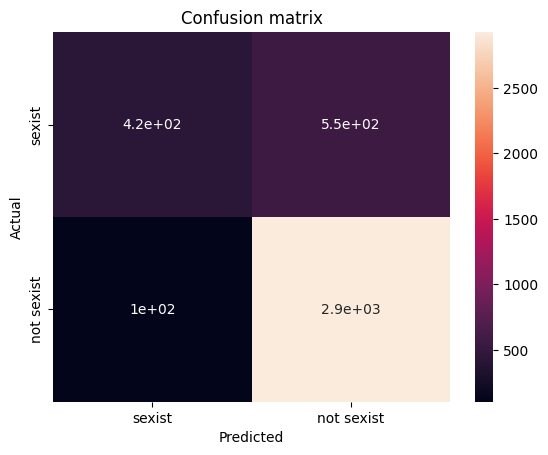

In [ ]:
ax = plt.axes()
sns.heatmap(confusion, annot=True,
           annot_kws={"size": 10},
           xticklabels=['sexist', 'not sexist'],
           yticklabels=['sexist', 'not sexist'], ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

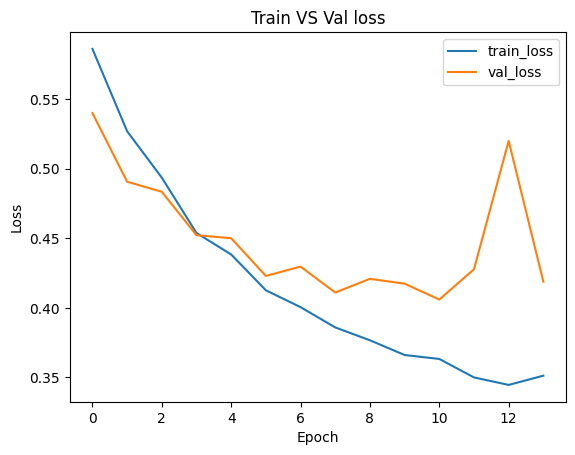

In [ ]:
# Plot the training and validation loss for each epoch
plt.plot(lstm_model_history.history['loss'], label='train_loss')
plt.plot(lstm_model_history.history['val_loss'], label='val_loss')
plt.title('Train VS Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

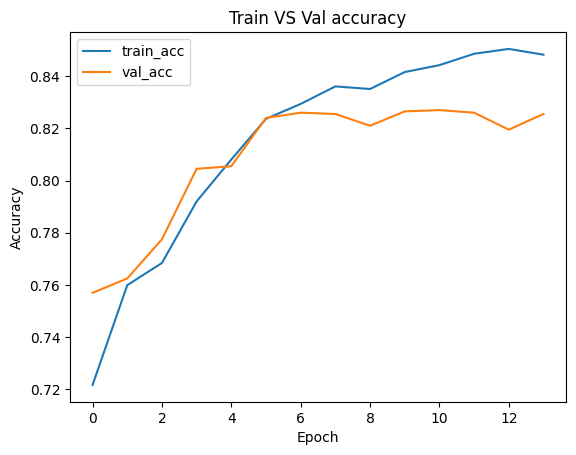

In [ ]:
# Plot the training and validation accuracy for each epoch
plt.plot(lstm_model_history.history['accuracy'], label='train_acc')
plt.plot(lstm_model_history.history['val_accuracy'], label='val_acc')
plt.title('Train VS Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
lstm_model.save('/content/drive/MyDrive/CSE440-Online Sexism/All Data/Models/LSTM/lstm-1.hdf5')

# **GRU (RNN)**

In [ ]:
from keras.layers import GRU

In [ ]:
# GRU
gru_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

gru_model.add(embedding_layer)
gru_model.add(Bidirectional(GRU(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
gru_model.add(Bidirectional(GRU(64, dropout=0.5, recurrent_dropout=0.2, activation='relu')))

gru_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=met)
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 300)           6788700   
                                                                 
 bidirectional_2 (Bidirecti  (None, 60, 1024)          2500608   
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               418560    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9707997 (37.03 MB)
Trainable params: 2919297 (11.14 MB)
Non-trainable params: 6788700 (25.90 MB)
_________________________________________________________________
None


In [ ]:
# Model Training

gru_model_history = gru_model.fit(x_train, y_train, batch_size=1024, epochs=15, verbose=1, validation_data=(x_val, y_val), callbacks=[checkpoint_gru, early_stopping])

Epoch 1/15
14/14 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.7600 - precision: 0.7749 - recall: 0.9628
Epoch 1: val_loss improved from inf to 0.53988, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/GRU/gru-01-0.5399.hdf5
14/14 [==============================] - 34s 1s/step - loss: 0.5705 - accuracy: 0.7600 - precision: 0.7749 - recall: 0.9628 - val_loss: 0.5399 - val_accuracy: 0.7565 - val_precision: 0.7569 - val_recall: 0.9993
Epoch 2/15
14/14 [==============================] - ETA: 0s - loss: 0.5337 - accuracy: 0.7570 - precision: 0.7575 - recall: 0.9989
Epoch 2: val_loss improved from 0.53988 to 0.50586, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/GRU/gru-02-0.5059.hdf5
14/14 [==============================] - 17s 1s/step - loss: 0.5337 - accuracy: 0.7570 - precision: 0.7575 - recall: 0.9989 - val_loss: 0.5059 - val_accuracy: 0.7625 - val_precision: 0.7620 - val_recall: 0.9980
Epoch 3/15

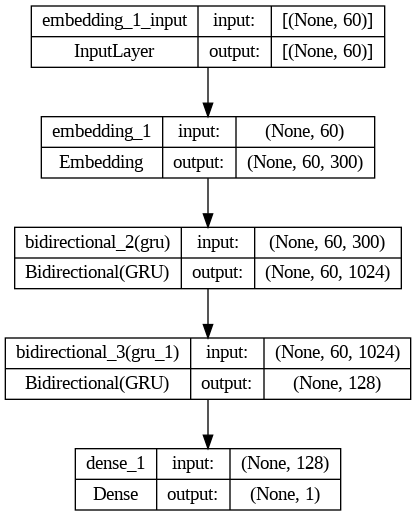

In [ ]:
#Plot Model Arch.
plot_model(gru_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Predictions on the Test Set

score = gru_model.evaluate(x_test, y_test, verbose=1)

125/125 [==============================] - 10s 82ms/step - loss: 0.3858 - accuracy: 0.8340 - precision: 0.8498 - recall: 0.9485


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.385761559009552
Test Accuracy: 0.8339999914169312


In [ ]:
preds = gru_model.predict(x_test)
preds = [np.round(x[0]) for x in preds]
print(classification_report(y_test,preds))

125/125 [==============================] - 11s 83ms/step
              precision    recall  f1-score   support

           0       0.75      0.48      0.58       970
           1       0.85      0.95      0.90      3030

    accuracy                           0.83      4000
   macro avg       0.80      0.71      0.74      4000
weighted avg       0.83      0.83      0.82      4000



In [ ]:
# Generate a confusion matrix
confusion = confusion_matrix(y_test, preds)
print("Confusion Matrix for Test Data using GRU")
print(confusion)

Confusion Matrix for Test Data using GRU
[[ 462  508]
 [ 156 2874]]


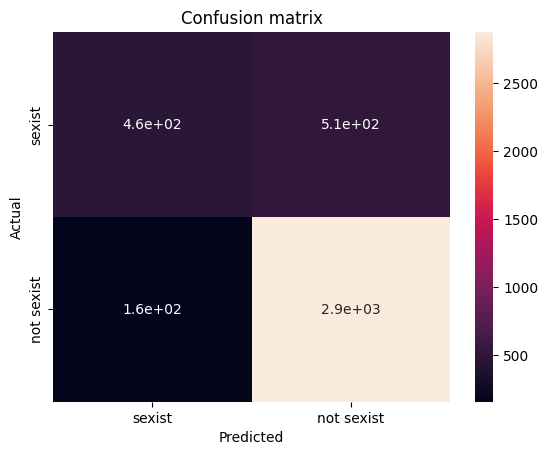

In [ ]:
ax = plt.axes()
sns.heatmap(confusion, annot=True,
           annot_kws={"size": 10},
           xticklabels=['sexist', 'not sexist'],
           yticklabels=['sexist', 'not sexist'], ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

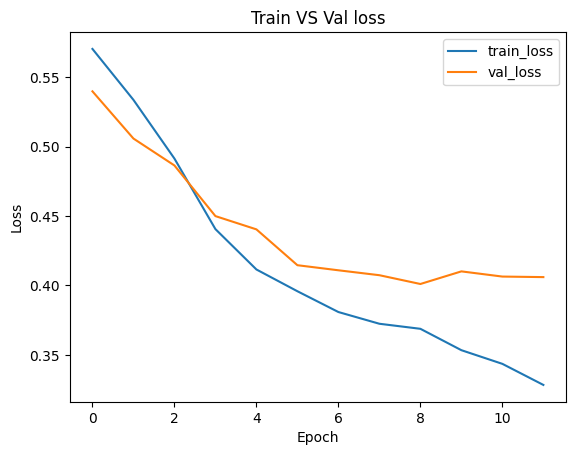

In [ ]:
# Plot the training and validation loss for each epoch
plt.plot(gru_model_history.history['loss'], label='train_loss')
plt.plot(gru_model_history.history['val_loss'], label='val_loss')
plt.title('Train VS Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

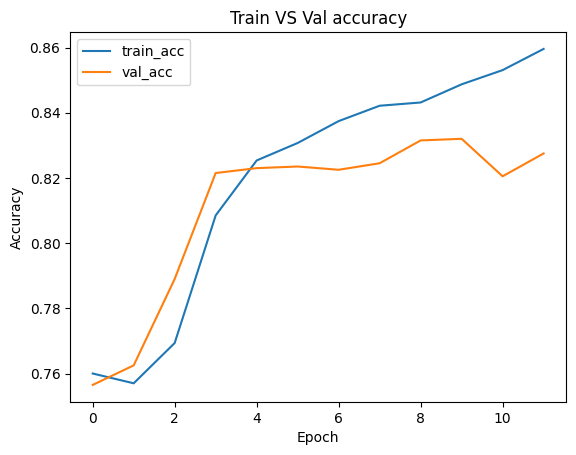

In [ ]:
# Plot the training and validation accuracy for each epoch
plt.plot(gru_model_history.history['accuracy'], label='train_acc')
plt.plot(gru_model_history.history['val_accuracy'], label='val_acc')
plt.title('Train VS Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
gru_model.save('/content/drive/MyDrive/CSE440-Online Sexism/All Data/Models/GRU/gru-1.hdf5')

# **CNN**

In [ ]:
from keras.layers import Conv1D

In [ ]:
#CNN

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(512, 5, activation='relu'))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())

cnn_model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(learning_rate=1e-5)

In [ ]:
# Model compiling

cnn_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=met)
print(cnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 60, 300)           6788700   
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 512)           768512    
                                                                 
 conv1d_3 (Conv1D)           (None, 54, 64)            98368     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7655645 (29.20 MB)
Trainable params: 866945 (3.31 MB)
Non-trainable params: 6788700 (25.90 MB)
___________

In [ ]:
# Model training

cnn_model_history = cnn_model.fit(x_train, y_train, batch_size=512, epochs=500, verbose=1, validation_data=(x_val, y_val), callbacks=[checkpoint_cnn, early_stopping])

Epoch 1/500
28/28 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.3885 - precision: 0.8412 - recall: 0.2374
Epoch 1: val_loss improved from inf to 0.72136, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/CNN/cnn-01-0.7214.hdf5
28/28 [==============================] - 11s 144ms/step - loss: 0.8830 - accuracy: 0.3885 - precision: 0.8412 - recall: 0.2374 - val_loss: 0.7214 - val_accuracy: 0.4010 - val_precision: 0.7484 - val_recall: 0.3144
Epoch 2/500
27/28 [===========================>..] - ETA: 0s - loss: 0.6550 - accuracy: 0.6365 - precision: 0.7506 - recall: 0.7793
Epoch 2: val_loss improved from 0.72136 to 0.59968, saving model to /content/drive/MyDrive/CSE440-Online Sexism/All Data/Checkpoint/CNN/cnn-02-0.5997.hdf5
28/28 [==============================] - 1s 45ms/step - loss: 0.6545 - accuracy: 0.6374 - precision: 0.7500 - recall: 0.7817 - val_loss: 0.5997 - val_accuracy: 0.7510 - val_precision: 0.7566 - val_recall: 0.9894
Epoc

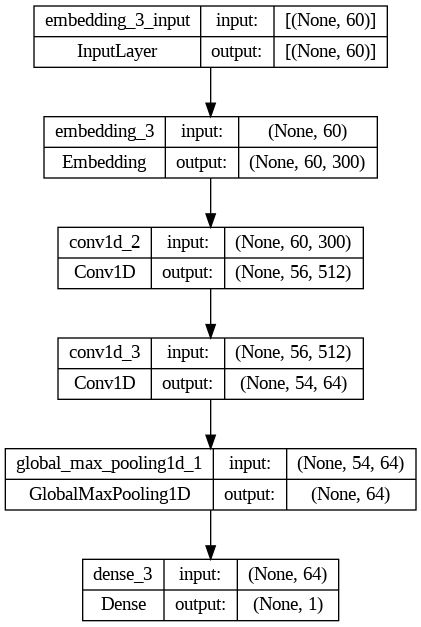

In [ ]:
#Plot Model Arch.
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(x_test, y_test, verbose=1)

125/125 [==============================] - 1s 5ms/step - loss: 0.4040 - accuracy: 0.8263 - precision: 0.8323 - recall: 0.9650


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.40396374464035034
Test Accuracy: 0.8262500166893005


In [ ]:
preds = cnn_model.predict(x_test)
preds = [round(x[0]) for x in preds]
print(classification_report(y_test,preds))

125/125 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.39      0.52       970
           1       0.83      0.97      0.89      3030

    accuracy                           0.83      4000
   macro avg       0.81      0.68      0.71      4000
weighted avg       0.82      0.83      0.80      4000



In [ ]:
# Generate a confusion matrix
confusion = confusion_matrix(y_test, preds)
print("Confusion Matrix for Test Data using CNN")
print(confusion)

Confusion Matrix for Test Data using CNN
[[ 381  589]
 [ 106 2924]]


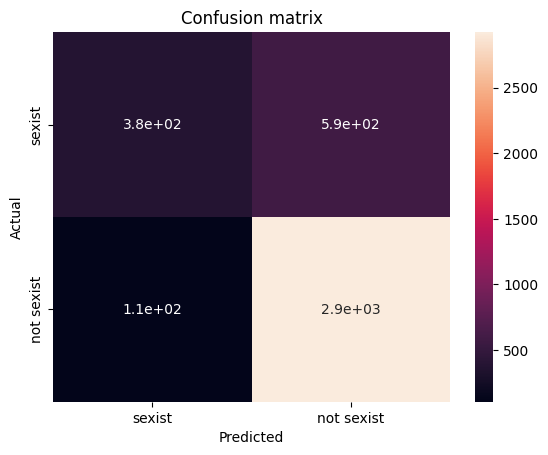

In [ ]:
ax = plt.axes()
sns.heatmap(confusion, annot=True,
           annot_kws={"size": 10},
           xticklabels=['sexist', 'not sexist'],
           yticklabels=['sexist', 'not sexist'], ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
ax.set_title('Confusion matrix')
plt.show()

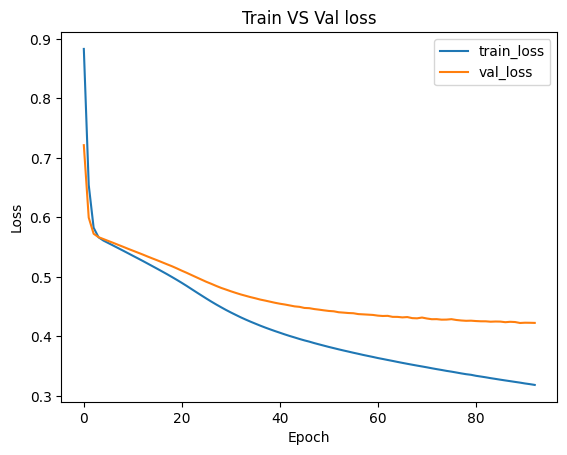

In [ ]:
# Plot the training and validation loss for each epoch
plt.plot(cnn_model_history.history['loss'], label='train_loss')
plt.plot(cnn_model_history.history['val_loss'], label='val_loss')
plt.title('Train VS Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

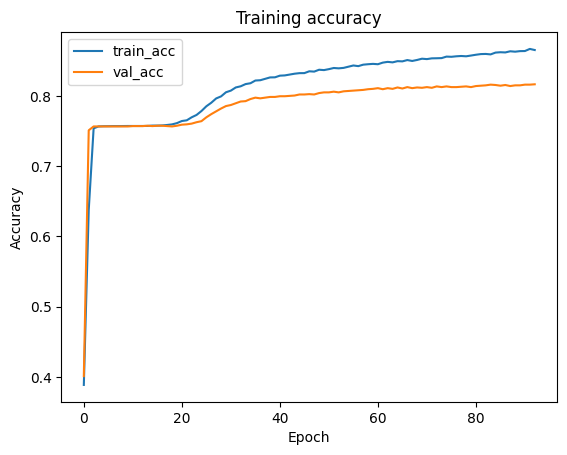

In [ ]:
# Plot the training and validation accuracy for each epoch
plt.plot(cnn_model_history.history['accuracy'], label='train_acc')
plt.plot(cnn_model_history.history['val_accuracy'], label='val_acc')
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
cnn_model.save('/content/drive/MyDrive/CSE440-Online Sexism/All Data/Models/CNN/cnn-1.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
